In [1]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import scrab_data

In [2]:
class Environment:
    def __init__(self):
        self.stocks_objects = list()

env = Environment()

In [3]:
screener = [
    "GOOG", 
    "AMZN", 
    # "META", 
    # "AVGO", 
    # "ORCL", 
    # "LLY", 
    # "NFLX", 
    # "ABBV", 
    # "ASML", 
    # "SAP", 
    # "CRM", 
    # "INTU", 
    # "NOW", 
    # "ISRG", 
    # "ADBE", 
    # "SPOT", 
    # "CRWD", 
    # "SE", 
    # "CDNS", 
    # "CI", 
    # "RMD", 
    # "EFX", 
    # "PTC", 
    # "PINS", 
    # "FSLR", 
    # "DKNG", 
    # "BE", 
    # "TRU", 
    # "OKTA", 
    # "DT"
]

In [4]:
class Stock:
    def __init__(self, ticker):
        self.ticker = ticker
        self.df = pd.DataFrame()

        # Fetched metrics
        self.fetch_metric("price")
        self.fetch_metric("price_target")
        self.fetch_metric("price_target_upside")
        self.fetch_metric("forward_pe_ratio")

        # Placeholder metrics
        # Initialize buy / sell to false
        for col in ['buy', 'sell']:
            if col not in self.df.columns:
                self.df[col] = False
                
        self.postprocess_metrics()
        env.stocks_objects.append(self)

    def fetch_metric(self, metric):
        response_metric = self._request_data(self.ticker, metric)
        metric_df = pd.DataFrame(response_metric[0]['datapoints'], columns=['timestamp', metric])
        metric_df.insert(0, 'date', pd.to_datetime(metric_df['timestamp'], unit='s'))
        metric_df = metric_df.drop(columns='timestamp')
        if self.df.empty:
            self.df = metric_df
        else:
            self.df = pd.merge(self.df, metric_df, on='date', how='left')

    def postprocess_metrics(self):
        # Forward fill price targets
        self.df['price_target'] = self.df['price_target'].ffill()
        
        # TODO: Improveme it, maybe move somewhere else as the definition for "good deal" should be customizable
        # Get buy / sell bands based on 3 sigma (2 sigma for buy, 1 sigma for sell)
        self.get_sigma()


    def _request_data(self, ticker, metric):
        url = "https://app.scrab.com/data/metric/"
        payload = {
        "tickers":[ticker],
        "metrics":[metric],
        "economic":[],
        "index":1
        }
        cookies = {
            "sessionid": scrab_data.SESSION_ID,
            "csrftoken": scrab_data.CSRF_TOKEN
        }
        headers = {
            "Content-Type": "application/json",
            "User-Agent": "Mozilla/5.0",
            "X-CSRFToken": scrab_data.CSRF_TOKEN,
            "Referer": "https://app.scrab.com/charts/master/",
            "Origin": "https://app.scrab.com"
        }
        response = requests.post(url, json=payload, headers=headers, cookies=cookies)
        data = response.json()
        return data
  
    def plot(self, title, metrics, log_scale=False, start_date="1900-01-01"):
        df_plot = self.df[self.df['date'] >= pd.to_datetime(start_date)]
        fig, ax = plt.subplots(figsize=(12,6))
        for metric in metrics:
            ax.plot(df_plot['date'], df_plot[metric], label=metric)
            ax.set_title(title)
            ax.set_xlabel('Date')
            ax.set_ylabel(str(metrics))
            ax.legend()
            ax.grid(True)
            if log_scale:
                ax.set_yscale('log')  # make y-axis logarithmic
        return ax

    def get_sigma(self, window=504):
        smooth_window = 40 

        # rolling mean & std
        self.df['ptu_mean'] = self.df['price_target_upside'].rolling(window, min_periods=1).mean()
        self.df['ptu_std'] = self.df['price_target_upside'].rolling(window, min_periods=1).std()

        # smooth mean & std
        self.df['ptu_mean_smooth'] = self.df['ptu_mean'].rolling(smooth_window, min_periods=1).mean()
        self.df['ptu_std_smooth'] = self.df['ptu_std'].rolling(smooth_window, min_periods=1).mean()

        # bands
        self.df['upper_band'] = self.df['ptu_mean_smooth'] + 2 * self.df['ptu_std_smooth']
        self.df['lower_band'] = self.df['ptu_mean_smooth'] - 2 * self.df['ptu_std_smooth']
    

In [5]:
# msft = Stock("MSFT")
# ax = msft.plot("Price & Target", ["price", "price_target"], log_scale=True, start_date="2015-01-01")
# ax = msft.plot(
#     "Price target upside with sigma bands",
#     ["price_target_upside", "upper_band", "lower_band"],
#     start_date="2015-01-01"
# )

GOOG: SELL -- Upside -2.31, 1.0% worse than 2 sigma


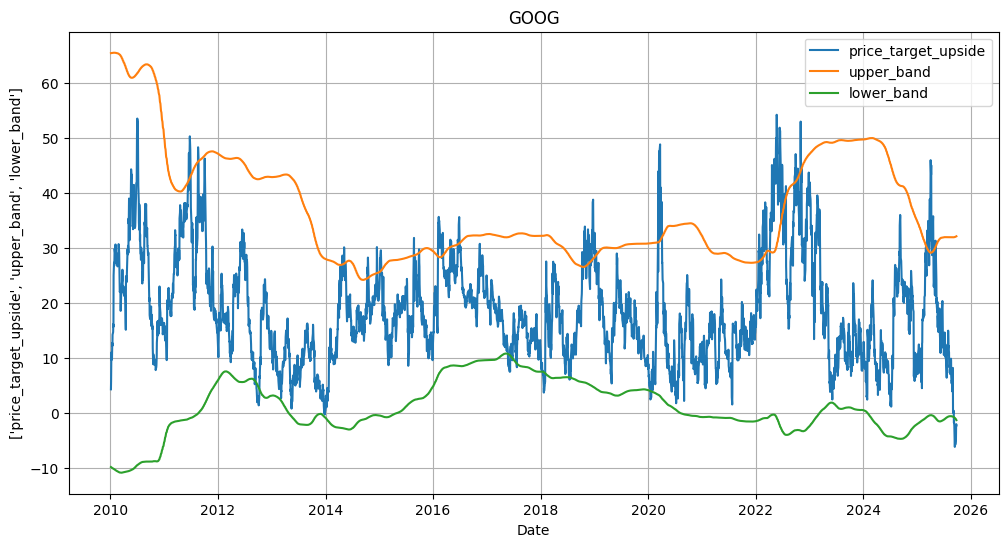

In [6]:
for ticker in screener:
    stock = Stock(ticker)
    latest_upside = stock.df['price_target_upside'].iloc[-1]
    latest_upper_band = stock.df['upper_band'].iloc[-1]
    latest_lower_band = stock.df['lower_band'].iloc[-1]
    if latest_upside >= latest_upper_band:
        print(f"{stock.ticker}: BUY -- Upside {latest_upside:.2f}, {latest_upside-latest_upper_band:.1f}% better than 2 sigma")
        ax = stock.plot(
        stock.ticker,
        ["price_target_upside", "upper_band", "lower_band"],
        start_date="2010-01-01"
        )
    if latest_upside <= latest_lower_band:
        print(f"{stock.ticker}: SELL -- Upside {latest_upside:.2f}, {latest_lower_band-latest_upside:.1f}% worse than 2 sigma")
        ax = stock.plot(
        stock.ticker,
        ["price_target_upside", "upper_band", "lower_band"],
        start_date="2010-01-01"
        )

In [7]:
class Screener:
    def __init__(self):
        self.tickers = list()

In [8]:
class Strategy:
    def __init__(self, buy_rule, sell_rule):
        self.buy_rule = buy_rule    # function: row -> bool
        self.sell_rule = sell_rule  # function: row -> bool

    def should_buy(self, row):
        return self.buy_rule(row)

    def should_sell(self, row):
        return self.sell_rule(row)

In [9]:
class Scorer:
    def __init__(self, stocks, criteria):
        self.stocks = stocks
        # What criteria?
        self.criteria = criteria

In [10]:
class AssetAllocator:
    def __init__(self, stocks, allocation):
        self.stocks = stocks
        self.stock_to_allocation = dict()
        allowed_allocation = set('equal_weights')
        if allocation not in allowed_allocation:
            raise ValueError(f'allocation must be one of {allowed_allocation}, got {allocation}')
        self.allocation = allocation

        match self.allocation:
            case 'equal_weights':
                n = len(self.stocks)
                self.stock_to_allocation = {stock: 1 / n for stock in stocks}


In [ ]:
class PortfolioBacktester:
    def __init__(self, stocks, strategy, initial_cash=1000, start_date = "2010-01-01"):
      self.stocks = stocks
      self.strategy = strategy
      self.cash = initial_cash
      self.simulation_date = pd.to_datetime(start_date)
      self.positions = {}  # ticker -> shares
      self.history = []
        
    def run(self):
        # Inital pass for portioning. We don't know 
        for stock in self.stocks:
            last_trading_day = stock.df['date'].max()
            today = pd.Timestamp.today().normalize()
            stop_date = min(last_trading_day, today)
            
            print(f'Simulation time: {(stop_date - self.simulation_date).days} days')

            while self.simulation_date <= stop_date:
                # Sometime start date is non-trading day, find first date that matches the start date
                df_slice = stock.df[stock.df['date'] <= self.simulation_date]
                latest_date = df_slice.iloc[-1]['date']
                latest_row = df_slice.iloc[-1]
                # Determine which stocks to buy
                buy = strategy.should_buy(latest_row)
                sell = strategy.should_sell(latest_row)
                assert not (buy and sell)
                if buy:
                    stock.df.loc[stock.df['date'] == latest_date, 'buy'] = buy
                elif sell:
                    stock.df.loc[stock.df['date'] == latest_date, 'sell'] = sell

                self.simulation_date += pd.Timedelta(days=1)

                # Decide stock allocation
                

buy_rule = lambda row: row['price_target_upside'] > row['upper_band']
sell_rule = lambda row: row['price_target_upside'] < row['lower_band']
allocation = 'equal_weights'
strategy = Strategy(buy_rule, sell_rule)
test_stocks = [Stock('MSFT')]
backtester = PortfolioBacktester(test_stocks, strategy, initial_cash=1000)
backtester.run()

Simulation time: 5747 days
